In [1]:
from datetime import datetime
from datetime import timedelta
import time
from nltk.stem import PorterStemmer
from nltk.stem import LancasterStemmer
import sklearn
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import pandas as pd
import seaborn as sns
from functools import reduce
import ast

Scaler = MinMaxScaler()
porter = PorterStemmer()
lancaster=LancasterStemmer()

In [17]:
df = pd.read_csv('../data/processed/headlines_cl_sent.csv').drop(["Unnamed: 0", "clean_headline_str"], axis=1)
df_base = pd.read_csv('../data/processed/headlines_cl_sent_base.csv').drop("Unnamed: 0", axis=1)

In [19]:
df['clean_hl_words'] = df['clean_hl_words'].apply(lambda row: ast.literal_eval(row))
# turn words into sets so we can compute intersection
df['clean_hl_words'] = df['clean_hl_words'].apply(lambda row: set([w.lower() for w in row]))
df['hl_words'] = df['headline_no_site'].apply(lambda row: set([w.lower() for w in row.split()]))

In [213]:
# def calc_publishing_time(scrape_date, duration):
#     date = 0
#     if duration[1] in ['week', 'weeks', 'weken']:
#         date = datetime(scrape_date) - timedelta(weeks=int(duration[0]))
#     elif duration[1] in ['days', 'day', 'dagen']:
#         date = datetime(scrape_date) - timedelta(days=int(duration[0]))
#     elif duration[1] in ['hour', 'hours', 'uur']:
#         date = datetime(scrape_date) - timedelta(hours=int(duration[0]))
#     return date
    

In [214]:
#calc_publishing_time(df['scrape_date'][0], df['time'].str.split(' ')[0])

In [20]:
#Two lists  of words that are used when a man or woman is present, based on Danielle Sucher's https://github.com/DanielleSucher/Jailbreak-the-Patriarchy
# male_words=set(['guy','spokesman','chairman',"men's",'men','him',"he's",'his','boy','boyfriend','boyfriends','boys','brother','brothers','dad','dads','dude','father','fathers','fiance','gentleman','gentlemen','god','grandfather','grandpa','grandson','groom','he','himself','husband','husbands','king','male','man','mr','nephew','nephews','priest','prince','son','sons','uncle','uncles','waiter','widower','widowers'])

female_words=set(['actress',  'actresses',  'airwomen',  'alderwoman',  'alderwomen',  'anchorwoman',  'anchorwomen',  
                  'archduchess',  'archduchesses',  'assemblywoman',  'assemblywomen',  'aunt',  'aunts',  'baroness',  
                  'baronesses',  'baronetess',  'baronetesses',  'bogeywoman',  'bogeywomen',  'bondswoman',  'bondswomen',  
                  'bride',  'businesswoman',  'businesswomen',  'camerawoman',  'camerawomen',  'cavewoman',  'cavewomen',  
                  'chairwoman',  'chairwomen',  'clergywoman',  'clergywomen',  'comtesse',  'congresswoman',  'congresswomen',  
                  'councilwoman',  'councilwomen',  'countess',  'countesses',  'countrywoman',  'countrywomen',  'craftswoman',  
                  'craftswomen',  'damsel',  'daughter',  'daughters',  'deaconess',  'deaconesses',  'diva',  'donna’, ‘housewife',  
                  'doorwoman',  'doorwomen',  'duchess',  'duchesses',  'empress',  'empresses',  'fem',  'female',  'females',  
                  'fiancee',  'firewoman',  'firewomen',  'fisherwoman',  'fisherwomen',  'forewoman',  'forewomen',  'freshwoman',  
                  'freshwomen',  'gal',  'galpal',  'gals',  'garbagewoman',  'garbagewomen',  'gentleman',  'girl',  'girlfriend',  
                  'girlfriends',  'girls',  'goddess',  'goddesshead',  'goddesshood',  'goddessliness',  'goddessly',  'godmother',  
                  'granddaughter',  'grandma',  'grandmas',  'grandmother',  'handywoman',  'handywomen',  'hangwoman',  'hangwomen',  
                  'henchwoman',  'henchwomen',  'her',  'heroine',  'heroines',  'herself',  'housewife',  'journeywoman',  'journeywomen',  
                  'kinswoman',  'kinswomen',  'klanswoman',  'ladies',  'ladiez',  'lady',  'lady-romance',  'ladysplain',  'laydeez',  
                  'laywoman',  'laywomen',  "ma'am",  'madam',  'madwoman',  'madwomen',  'maiden',  'mailwoman',  'mailwomen',  'mama',  
                  'marchioness',  'margravine',  'markswoman',  'markswomen',  'marquise',  'middlewoman',  'middlewomen',  'milkwoman',  
                  'milkwomen',  'miss',  'mistress',  'mom',  'momma',  'mommies',  'mommy',  'moms',  'mother',  'mothersmrs',  'ms',  
                  'mum',  'mummy',  'mums',  'niece',  'nieces',  'noblewoman',  'noblewomen',  'ombudswoman',  'ombudswomen',  'policewoman',  
                  'policewomen',  'postwoman',  'postwomen',  'priestess',  'priestesses',  'princess',  'princesses',  'prostitute',  'queen',  
                  'queens',  'repairwoman',  'repairwomen',  'saleswoman',  'saleswomen',  'sandwoman',  'sandwomen',  'servicewoman',  
                  'servicewomen',  'she',  "she's",  'showwoman',  'showwomen',  'sis',  'sistagrammer',  'sistas',  'sister',  'sisters',  
                  'snowwoman',  'spacewoman',  'spacewomen',  'spokeswoman',  'spokeswomen',  'sportswoman',  'sportswomen',  'stateswoman',  
                  'stateswomen',  'stepmother',  'stepsister',  'superwoman',  'superwomen',  'unwoman',  'viscountess',  'viscountesses',  
                  'waitress',  'watchwoman',  'watchwomen',  'weatherwoman',  'weatherwomen',  'widow',  'widows',  'wife',  'wives',  
                  'woman',  'womanhood',  'womankind',  'women',  "women's",  'workwoman',  'workwomen'])

# this list of words
female_bias_words = set(['adorable',  'affair',  'affection',  'affectionate',  'afraid',  'agree',  'angel',  'baby',  'banshee',  'barren',  
                         'beautiful',  'beauty',  'bikini',  'birth',  'bitch',  'bitchfest',  'bitchy',  'body',  'bossy',  'breast',  'bride',  
                         'bridezilla',  'bubbly',  'care',  'caress',  'caring',  'catfight',  'catty',  'chatty',  'cheat',  'cheer',  'child',  
                         'clotheshorse',  'clucky',  'co-operate',  'cold',  'collab',  'commit',  'commitment',  'committed',  'communal',  
                         'compassion',  'compassionate',  'conscientious',  'considerate',  'cook',  'cooking',  'cooperate',  'cougar',  
                         'cries',  'cry',  'crying',  'dedicated',  'demure',  'depend',  'dependable',  'diligent',  'ditzy',  'divorce',  
                         'domestic',  'drama',  'dramatic',  'dress',  'easy',  'emotion',  'emotiona',  'emotional',  'emotions',  'empath',  
                         'empathetic',  'empathize',  'enthusias',  'family',  'fear',  'feel',  'feeling',  'feisty',  'femaleness',  'feminazi',  
                         'feminine',  'fishwife',  'flaky',  'flatter',  'flatterable',  'flirty',  'frail',  'frigid',  'frumpy',  'gentle',  
                         'girlhood',  'girlier',  'girliest',  'girly',  'gossip',  'gossipy',  'helpful',  'honest',  'hormonal',  'houseproud',  
                         'humourless',  'hysterical',  'ice queen',  'inclusive',  'inter-dependen',  'inter-dependence',  'inter-dependent',  
                         'inter-personal',  'interdependence',  'interdependent',  'interpersonal',  'irrational',  'kid',  'kind',  'kinship',  
                         'ladylike',  'lie',  'lippy',  'loose',  'love',  'lover',  'loyal',  'maid',  'makeup',  'man-eater',  'man-hater',  
                         'marriage',  'married',  'marrigeable',  'marry',  'maternal',  'maternal ',  'menstrual ',  'mistress',  'modest',  
                         'modesty',  'moody',  'mousey',  'mumpreneur',  'mumsy',  'nag',  'naked',  'neurotic',  'new born',  'new-born',  
                         'newborn',  'nurse',  'nurtur',  'nurture',  'nurtures',  'nurturing',  'obedient',  'obey',  'over-sensitive',  
                         'pleasant',  'polite',  'powerless',  'pregnancy',  'pretty',  'prostitute',  'prude',  'quiet',  'relationship',  
                         'respon',  'sassy',  'secretary',  'seduce',  'seductive',  'sensitiv',  'sensitive',  'sex',  'sexual',  'sexually',  
                         'share',  'sharin',  'shop',  'shopping',  'shrew',  'single',  'slut',  'slutty',  'soft',  'spinster',  'submissive',  
                         'supermum',  'support',  'sympath',  'sympathy',  'tactful',  'tease',  'tender',  'together',  'tomboy ',  'trollop',  
                         'trust',  'understand',  'victim',  'virgin',  'vivacious',  'warm',  'weak',  'wedding',  'weight',  'whin',  
                         'whitefemaleness',  'whore',  'womanlier',  'womanliest',  'womanliness',  'womanly',  'yield'])

male_words = set(['hero', 'man',  'men', 'his', 'him', 'he', 'husband', 'father', 'male', 'son', 'god',
                  'prince', 'king', 'mr', 'sir', 'brother', 'grandfather', 'uncle', 'nephew', 'master', 'patriarch',
                 'chairman', 'chairmen', "boy","boyfriend", "save", "guy", "dad"])

discrimination_words = set(['race', 'caste', 'casteless', 'black', 'SC', 'ST', 'african american', 'white', 'colour', 
                            'color', "brown", "asian", "native", "racial", "minority", "ethnic", "ethnicity", "indian",
                            'hindu', "muslim", "chinese", "indian"])

male_bias_words = set(["active", "adventurous", "aggression",'aggressive', "ambition", "assert", 'assertive',
                       "athlete", 'athletic', "battle", "champion", "decisive", 'head', 'dominate', 'dominant',
                        "driven", 'confident', 'strong', 'force', 'master', 'superior', 'strength', 'bold', 
                       'ambitious', 'power', 'intelligent', 'greedy', 'hostile', 'uncaring', 'logic', 'logical', 'rational',
                       "fearless",'stubborn', 'independent', 'objective', "charismatic"])

empowerement_words = set(['chairperson', 'leader','leadership',  'chairwoman', 'minister', 'power','powerful', 'authority', 
                          'queen', 'manager', 'success', 'successful', 'successes', 'career', 'job',
                         'CEO','CFO', 'chief', 'officer', 'employment', 'employed', 'millionaire', 
                          'wealth', 'wealthy', 'strong', 'strength', 'courage','achievement', 'achievements', 
                          'achieve', 'goal', 'ambition', 'ambitious', 'passionate','passion', 'badass', 
                          'confident', 'confidence', 'breakthrough', "inspirational", "educated"
                         'inspiring', 'inspiration', 'inspire', 'empower', 'empowered', 'empowerement',
                         'genius', 'expert', 'mastery', 'owner', 'businesswoman', 'intelligent', 'smart', 
                          'clever', 'wise', 'worth', 'role model', 'role-model', 'activist', "pay", "work", 
                          "business", "win", "award", "appoint", "lead", "star", "boss", "dream",'goddess', 
                          "actor", 'queen', "launch", "worker", "lawyer", "education", "director", "protester", 
                          "protest", "governor", "survive", "stallion", "doctor", "voice", "perfect", "author",
                          "mayor", "founder", "abortion", "rise", "1st", "winner", "artist", "graduate", 
                          "employee", "earning", "survivor", "scientist", "equality", "equal", "deputy", 
                          "entrepreneur", "survive", "parent"])

politics_words = set(["trump", "biden", "kamala", "harris", "joe", "vote", "election", "president", "elect", 
                      "state", "government", "obama", "office", "campaign", "melania", "vice", "govt", "donald", 
                      "voter", "congress", "candidate", "political", "breonna", "taylor", "pelosi", "democratic",
                      "politic", "democrats", "republican", "ivanka", "republicans", "hillary", "clinton", "susan", 
                      "collins", "warren", "rep", "rally", "debate", "senate", "washington", "speech", "presidential",
                      "boris", "mandela"])

violence_words = set(["find", "allegedly", "fire", "life", 'violent', 'violence', 'crime', 'rape','rapist', 'raped', 'murder','kill', 'killed','killer',
                     'murdered', 'murderer', 'attack', 'alleged', 'criminal', 'stab', 'knife', 'gun', 'guns', 'knives',
                     'blood', 'bloodshed', 'court', 'rage', 'outrage', 'rob', 'steal', 'robber', 'stealer', 'beater', "beaten",
                     'domestic violence', 'aggression', 'aggressor', 'war', 'battle', 'abduction', 'assault', 'assaulted',
                     'drug', 'abuse', 'child abuse', 'prison', 'fraud', 'human traffic', 'homicide', 'organised crime',
                     'organized crime', 'genocide', 'fight', 'manslaughter', 'terrorist', 'weapon', 'smuggl', 'shoplift',
                     'vandalism', 'crime', 'theft', 'penalty', 'prison sentence', 'detained', 'guilty', 'trial',
                     'defense', 'defend', 'armed', 'jail', 'illegal', 'accomplice',
                     'alcohol', 'allegation', 'arson', 'bail', 'battery', 'dead', 'death', 'deadly', 'corrupt', 'killer', 
                     'sex crime', 'wanted', "arrest", "police", "die", "charge", "suspect", "shoot", "sentence", "cop", "hit", 
                     "break", "beat", "judge", "kidnap", "law", "corruption", "gang", "suicide", "critically injured", 'harassment',
                     "run", "crash", "hospital", 'security', "report", "risk", "fall", "burn", "escape", "threaten", "slam",
                     "gangrape", "harass", "brutally", "drown", "justice", "hate", "racist", "allege", "lawsuit", "injure", "racism", 
                      "thug", "suffer", "injury", "horror", "killing", "robbery", "plead", "wound", "kidnapping", "convict", "shooting"])

female_bias = female_words.union(female_bias_words)
male_bias = male_words.union(male_bias_words)

In [216]:
# def gender_the_sentence(sentence_words):
#     mw_length=len(male_words.intersection(sentence_words))
#     fw_length=len(female_words.intersection(sentence_words))

#     if mw_length>0 and fw_length==0:
#         gender='male'
#     elif mw_length==0 and fw_length>0: 
#         gender='female'
#     elif mw_length>0 and fw_length>0: 
#         gender='both'
#     else:
#         gender='none'
#     return gender

In [21]:
def gender_the_sentence(sentence_words, type_words):
#     mw_length=len(male_words.intersection(sentence_words))
    sentence_words = set([porter.stem(word) for word in sentence_words])
    type_words = set([porter.stem(word) for word in type_words])
    
    fw_length=len(type_words.intersection(sentence_words))

#     if mw_length>0 and fw_length==0:
#         gender='male'
    if fw_length>0: 
        
        gender=1
    else:
        gender=0
    return gender

In [22]:
def quantify_bias(sentence_words, type_words):
#     mw_length=len(male_words.intersection(sentence_words))

    sentence_words = set([porter.stem(word) for word in sentence_words])
    type_words = set([porter.stem(word) for word in type_words])
    f_bias_words = set([porter.stem(word) for word in female_bias_words])
    m_bias_words = set([porter.stem(word) for word in male_bias_words])
    
    type_length=len(type_words.intersection(sentence_words))
    bias_length = len(f_bias_words.intersection(sentence_words))
#     if bias_length>0:
#         print(sentence_words)
#         print(bias_length)

#     if mw_length>0 and fw_length==0:
#         gender='male'
    if type_length>0 and type_words == 'female_words': 
        bias=type_length + bias_length
    elif type_length>0 and type_words == 'male_words': 
        bias=type_length + len(m_bias_words.intersection(sentence_words))
    elif type_length>0 :
        bias = type_length
    else:
        bias=0
    return bias

In [23]:
def label_word_theme(word, type_words, themes):
    
    
    fw_length=len([porter.stem(word) for word in type_words[0]].intersection(set([porter.stem(word)])))
    mw_length=len([porter.stem(word) for word in type_words[1]].intersection(set([porter.stem(word)])))
    ew_length=len([porter.stem(word) for word in type_words[2]].intersection(set([porter.stem(word)])))
    vw_length=len([porter.stem(word) for word in type_words[3]].intersection(set([porter.stem(word)])))
#     r_length=len(type_words[4].intersection(set([word])))
#     p_length=len(type_words[5].intersection(set([word])))
#     if mw_length>0 and fw_length==0:
#         gender='male'
    if fw_length>0: 
        label=themes[0]
        
    elif mw_length>0: 
        label=themes[1]
        
    elif ew_length>0: 
        label=themes[2]
        
    elif vw_length>0: 
        label=themes[3]
        
#     elif r_length>0: 
#         label=themes[4]
        
#     elif p_length>0: 
#         label=themes[5]
    else:
        label=np.NaN
    return label


In [24]:
def label_word_theme(word, type_words, themes):
#     mw_length=len(male_words.intersection(sentence_words))
    fw_length=len([porter.stem(word) for word in type_words[0]].intersection(set([porter.stem(word)])))
    mw_length=len([porter.stem(word) for word in type_words[1]].intersection(set([porter.stem(word)])))
    ew_length=len([porter.stem(word) for word in type_words[2]].intersection(set([porter.stem(word)])))
    vw_length=len([porter.stem(word) for word in type_words[3]].intersection(set([porter.stem(word)])))
    r_length=len([porter.stem(word) for word in type_words[4]].intersection(set([porter.stem(word)])))
    p_length=len([porter.stem(word) for word in type_words[5]].intersection(set([porter.stem(word)])))
#     if mw_length>0 and fw_length==0:
#         gender='male'
    if fw_length>0: 
        label=themes[0]
        
    elif mw_length>0: 
        label=themes[1]
        
    elif ew_length>0: 
        label=themes[2]
        
    elif vw_length>0: 
        label=themes[3]
        
    elif r_length>0: 
        label=themes[4]
        
    elif p_length>0: 
        label=themes[5]
    else:
        label=np.NaN
    return label


In [25]:
%%time
# create bias columns
df['gendered'] = df['hl_words'].apply(lambda row: gender_the_sentence(row, female_words))
df['bias'] = df['hl_words'].apply(lambda row: quantify_bias(row, female_words))
# df['empowerement'] = df['hl_words'].apply(lambda row:quantify_bias(row, empowerement_words) )
# #df['male_words'] = df['hl_words'].apply(lambda row:quantify_bias(row, male_words) )
# df['male_bias'] = df['hl_words'].apply(lambda row:quantify_bias(row, male_words) )
# df['violence'] = df['hl_words'].apply(lambda row:quantify_bias(row, violence_words) )

Wall time: 2h 4min 30s


In [26]:
# bias calculation
df['bias'] = df['hl_words'].apply(lambda row: quantify_bias(row, female_words))

In [28]:
#polarity calculation
df['polarity'] = np.abs(df['compound_s'].values)
df_base['polarity_base'] = np.abs(df_base['compound_s'].values)

In [29]:
datatype = "rapi"
df.to_csv(f"../data/processed/headlines_cl_sent_pol_{datatype}.csv")
df = pd.read_csv(f"../data/processed/headlines_cl_sent_pol_{datatype}.csv")

In [30]:
# aggregate by site
df_site = df.groupby(by=['site', 'country_of_pub']).agg({'bias': 'sum', 
                                       'monthly_visits' :'mean', 
                                                        'polarity' : 'mean'}).reset_index().sort_values(by = 'bias', ascending = False).reset_index(drop=True)

df_site_base = df_base.groupby(by=['site', 'country_of_pub']).agg({
                                       'monthly_visits' :'mean', 
                                                        'polarity_base' : 'mean'}).reset_index()

In [31]:
# scale bias and polarity for both agg site data and raw data
df['bias'] = Scaler.fit_transform(df[['bias']])
df_site['bias'] = Scaler.fit_transform(df_site[['bias']])
df['polarity'] = Scaler.fit_transform(df[['polarity']])
df_site['polarity'] = Scaler.fit_transform(df_site[['polarity']])
df_site_base['polarity_base'] = Scaler.fit_transform(df_site_base[['polarity_base']])

In [32]:
df[['url', 'headline_no_site','site', 'time', 'country', 'bias']].to_csv(f'../data/processed/headlines_cl_sent_sm_{datatype}.csv')

In [33]:
newsrooms = pd.read_csv('../data/raw/newsrooms.csv')
newsrooms.columns = ['site', 'monthly_visits', 'country', 'country_of_pub']
site_views = newsrooms.groupby(by='site').agg({'monthly_visits': 'sum'}).reset_index()
#df_site = site_views.join(df_site[['site', 'country_of_pub', 'bias', 'male_bias', 'empowerement', 'polarity', 'violence']].set_index('site'), on = 'site')

C:\Users\Leonardo\Anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


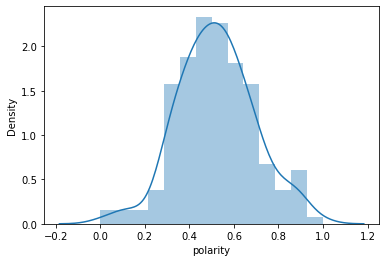

In [34]:
sns.distplot(df_site['polarity'])

In [35]:
newsrooms.head()

,site,monthly_visits,country,country_of_pub
0,economictimes.indiatimes.com,0,India,India
1,aajtak.in,681400000,India,India
2,yahoo.com,85920000,India,USA
3,indiatimes.com,81500000,India,India
4,ndtv.com,77830000,India,India


In [99]:
df_site

,site,country_of_pub,bias,monthly_visits,polarity
0,dailymail.co.uk,UK,1.000000,2429000,0.587956
1,mirror.co.uk,UK,0.762101,55700000,0.660242
2,telegraph.co.uk,UK,0.687277,169500000,0.501216
3,abcnews.go.com,USA,0.649811,159709000,0.530927
4,nydailynews.com,USA,0.644288,150664000,0.725295
...,...,...,...,...,...
180,news.google.com,USA,0.000217,19480000,0.733448
181,howtogeek.com,USA,0.000108,7200000,1.000000
182,dailysun.co.za,South Africa,0.000108,0,0.801696
183,makeuseof.com,UK,0.000108,6200000,0.000000


In [35]:
dfs = [df_site[['site', 'bias', 'polarity','country_of_pub']], site_views[['site', 'monthly_visits']]]
df_site_f = reduce(lambda left, right: pd.merge(left, right, on = 'site'), dfs)
df_site_f = pd.merge(df_site_f, df_site_base[['site', 'polarity_base']], on='site', how="left")

In [36]:
df_site_f['polarity_delta'] = (df_site_f['polarity']-df_site_f['polarity_base'])/df_site_f['polarity_base']

In [116]:
# df_site_f.describe()

In [37]:
df_site_f.to_csv(f'../data/processed/headlines_site_{datatype}.csv')

In [43]:
df_site_f[df_site_f['site'] == "ft.com"]

,site,bias,polarity,country_of_pub,monthly_visits,polarity_base,polarity_delta
174,ft.com,0.002776,0.328646,UK,19400000,0.341075,-0.03644


In [43]:
# df_country

#### Label word frequencies

In [61]:
# word frequencies
import numpy as np
countries_freq = pd.read_csv('../data/processed/countries_freq.csv')
sites_freq = pd.read_csv('../data/processed/sites_freq.csv')

C:\Users\Leonardo\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3147: DtypeWarning: Columns (7) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [62]:
countries_freq['theme'] = countries_freq['word'].apply(lambda word: label_word_theme(word, type_words=[female_bias, male_bias, 
                                                                                                       empowerement_words, violence_words, discrimination_words, politics_words], 
                                                                                     themes = ["female", "male", "empowerment", "violence", "race", "politics"]))

sites_freq['theme'] = countries_freq['word'].apply(lambda word: label_word_theme(word, type_words=[female_bias, male_words, 
                                                                                                       empowerement_words, violence_words, discrimination_words, politics_words], 
                                                                                     themes = ["female", "male", "empowerment", "violence", "race", "politics"]))
# normalize word frequencies within each country
countries_freq['perc_freq'] = np.NaN
sites_freq['perc_freq'] = np.NaN

for country in countries_freq['country'].unique():
    countries_freq['perc_freq'][countries_freq['country'] == country] = countries_freq['frequency'][countries_freq['country'] == country]/countries_freq['frequency'][countries_freq['country'] == country].head(1000).sum()
for site in sites_freq['site'].unique():
    sites_freq['perc_freq'][sites_freq['site'] == site] = sites_freq['frequency'][sites_freq['site'] == site]/sites_freq['frequency'][sites_freq['site'] == site].head(1000).sum()

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  del sys.path[0]
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [65]:
countries_freq.theme.unique()

array([nan, 'male', 'violence', 'female', 'race', 'empowerment',
       'politics'], dtype=object)

In [67]:
remove_words = ['say', 'new', 'time', "south", "africa", "india", "england", "united states", "american", "americans", 
             "UK", "get", "video", "tell", "cape", "makesefakese", "not", "no", "ask", "november", "c19", "covid19"]

In [69]:
countries_freq = countries_freq[~countries_freq['word'].isin(remove_words)]

In [70]:
len(countries_freq[countries_freq.theme.isna()==False])

1569

In [71]:
len(sites_freq[sites_freq.theme.isna()==False])

1512

In [72]:
countries_freq['cluster'] = np.NaN
for country in countries_freq['country'].unique():
    countries_freq['cluster'][countries_freq['country'] == country] = countries_freq['country'][countries_freq['country'] == country]+", "+ countries_freq['theme'][countries_freq['country'] == country]

C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
C:\Users\Leonardo\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
C:\Users\Leonardo\Anaconda3\lib\site-packages\pandas\core\generic.py:8767: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: ht

In [78]:
countries_clusters = countries_freq[countries_freq['theme'].isin(["female", "male", "empowerment", "violence"])].dropna()

In [79]:
countries_clusters.theme.unique()

array(['male', 'violence', 'female', 'empowerment'], dtype=object)

In [82]:
# countries_freq[countries_freq['country']=="India"].iloc[100:150, :]

In [80]:
countries_freq.to_csv('../data/processed/countries_freq.csv')
countries_clusters.to_csv('../data/processed/countries_clusters.csv')
sites_freq.to_csv('../data/processed/sites_freq.csv')